# **<font color=black>Noise-Tolerant Self-Supervised Inversion**

<font size = 4> We propose a general framework for solving inverse problems in the presence of noise that requires no signal prior, no noise estimate, and no clean training data. The only assumptions are that the forward model is available, differentiable and that the noise exhibits statistical independence across different measurement dimensions. We build upon the theory of 'J-invariant' functions [Batson & Royer 2019](https://arxiv.org/abs/1901.11365) and show how self-supervised denoising à la Noise2Self is a special case of learning a noise-tolerant pseudo-inverse of the identity. We demonstrate our approach by showing how a convolutional neural network can be taught in a self-supervised manner to deconvolve images and surpass in image quality classical inversion schemes such as Lucy-Richardson deconvolution. Here you can use SSI implementation on our example data or your own data.

---

<font size = 4>*Disclaimer*:

<font size = 4>This notebook is inspired from the *Zero-Cost Deep-Learning to Enhance Microscopy* project (ZeroCostDL4Mic) (https://github.com/HenriquesLab/DeepLearning_Collab/wiki) and was created by **<font color=black>Ahmet Can Solak and Loic Royer**

<font size = 4>This notebook is based on the following paper: 

<font size = 4>**Image Deconvolution via Noise-Tolerant Self-Supervised Inversion**, Hirofumi Kobayashi, Ahmet Can Solak, Joshua Batson, Loic A. Royer, [link to paper](https://royerlab.github.io/ssi-code/paper/Noise_Tolerant_Self_Supervised_Inversion.pdf)

<font size = 4>And source code found in: https://github.com/royerlab/ssi-code


<font size = 4>**Please also cite this original paper when using or developing this notebook.**

# **How to use this notebook?**

---

<font size = 4>Video describing how to use ZeroCostDL4Mic notebooks are available on youtube:
  - [**Video 1**](https://www.youtube.com/watch?v=GzD2gamVNHI&feature=youtu.be): Full run through of the workflow to obtain the notebooks and the provided test datasets as well as a common use of the notebook
  - [**Video 2**](https://www.youtube.com/watch?v=PUuQfP5SsqM&feature=youtu.be): Detailed description of the different sections of the notebook


---
###**Structure of a notebook**

<font size = 4>The notebook contains two types of cell:  

<font size = 4>**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

<font size = 4>**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appears). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Table of contents, Code snippets** and **Files**

<font size = 4>On the top left side of the notebook you find three tabs which contain from top to bottom:

<font size = 4>*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

<font size = 4>*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

<font size = 4>*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

<font size = 4>**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

<font size = 4>**Note:** The "sample data" in "Files" contains default files. Do not upload anything in here!

---
###**Making changes to the notebook**

<font size = 4>**You can make a copy** of the notebook and save it to your Google Drive. To do this click file -> save a copy in drive.

<font size = 4>To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
You can use the `#`-mark in code cells to comment out parts of the code. This allows you to keep the original code piece in the cell as a comment.

# **1. Initialise the Colab session**
---







## **1.1. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelator: GPU** *(Graphics processing unit)*


In [ ]:
#@markdown ##Run this cell to check if you have GPU access
%tensorflow_version 1.x

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

from tensorflow.python.client import device_lib 
device_lib.list_local_devices()


## **1.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

# **2. Install <font color=black>SSI<font color=white> and Dependencies**
---


In [11]:
#@markdown ##<font color=black>Install Network and Dependencies


#Libraries contains information of certain topics. 
!pip install git+https://github.com/royerlab/ssi-code.git
!pip install cupy-cuda101

#Put the imported code and libraries here
import ssi

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Depencies installed and imported.")





#######
import sys
import time
from pathlib import Path
import numpy
from tifffile import imread, imsave
import napari
from matplotlib import pyplot as plt

from ssi.demo.demo3D import printscore
from ssi.ssi_deconv import SSIDeconvolution
from ssi.lr_deconv import ImageTranslatorLRDeconv
from ssi.models.unet import UNet
from ssi.utils.io.datasets import normalise, add_poisson_gaussian_noise, add_microscope_blur_3d
from ssi.utils.metrics.image_metrics import psnr, spectral_mutual_information, mutual_information, ssim




  Cloning https://github.com/royerlab/ssi-code.git to /tmp/pip-req-build-i__qslqw
  Running command git clone -q https://github.com/royerlab/ssi-code.git /tmp/pip-req-build-i__qslqw
  Created wheel for ssi: filename=ssi-0.0.1-cp36-none-any.whl size=65150 sha256=9cced5a97e05558c67b49081a7528a5e2e992f39f4f8aa0889023378419cbf8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-kmno55om/wheels/41/43/79/772d902b235a4becec95b28b90f55916d5739a008dd2ccef03
Successfully built ssi
Depencies installed and imported.


# **3. Select your paths and parameters**

---

<font size = 4>The code below allows the user to enter the paths to where the training data is and to define the training parameters.


## **3.1. Setting Main Training Parameters**
---
<font size = 4>

<font size = 5> **Paths for training, predictions and results**

<font size = 4 color=orange> Fill the parameters here as needed and update the code. Note that the sections containing `Training_source`, `Training target`, `model_name` and `model_path` should appear in your notebook.

<font size = 4>**`Training_source:`, `Training_target`:** These are the paths to your folders containing the Training_source and Training_target data respectively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 5>**Training Parameters**

<font size = 4>**`number_of_epochs`:**Give estimates for training performance given a number of epochs and provide a default value. **Default value:**

<font size = 4>**`other_parameters`:**Give other parameters or default values **Default value:**

<font size = 4>**If additional parameter above affects the training of the notebook give a brief explanation and how problems can be mitigated**<font size = 4> 


<font size = 5>**Advanced Parameters - experienced users only**

<font size = 4>**`number_of_steps`:** Define the number of training steps by epoch. By default this parameter is calculated so that each patch is seen at least once per epoch. **Default value: Number of patch / batch_size**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 16**

<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during training. **Default value: 10** 

Loaded Input images (number, width, length) = (64, 64, 64)
Parameters initiated.
Image dimensions (z,y,x) (64, 64, 64)


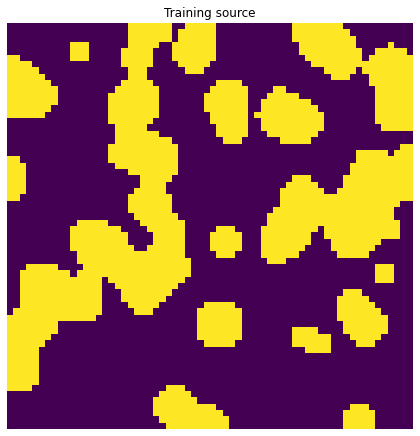

In [13]:
class bcolors:
  WARNING = '\033[31m'


#@markdown ###Path to training images:

Training_source = "/content/gt" #@param {type:"string"}

Image_name = "blob_3d" #@param {type:"string"}

folder = Path(Training_source)
files = [f for f in folder.iterdir() if f.is_file()]
filename = [f.name for f in files if Image_name in f.name][0]
filepath = folder / filename
image = imread(filepath)



# other parameters for training.
#@markdown ###Training Parameters

max_epochs =  3000#@param {type:"number"}

patience =  300#@param {type:"number"}

batch_size =  8#@param {type:"number"}


print('Loaded Input images (number, width, length) =', image.shape)
print("Parameters initiated.")



# Here we check that the input images contains the expected dimensions
if len(image.shape) == 3:
  print("Image dimensions (z,y,x)",image.shape)

if not len(image.shape) == 3:
  print(bcolors.WARNING +"Your images appear to have the wrong dimensions. Image dimension", image.shape)



f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(image[:,:,0], interpolation='nearest')
plt.title('Training source')
plt.axis('off');




# **4. Train the network**
---

## **4.1. Train the network**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.

In [ ]:
import time
import csv

start = time.time()

#@markdown ##<font color=black>Start Training

# Start Training

#Insert the code necessary to initiate training of your model

#Note that the notebook should load weights either from the model that is 
#trained from scratch or if the pretrained weights are used (3.3.)



print("beginning of demo")
image_clipped = normalise(image.astype(numpy.float32))
blurred_image, psf_kernel = add_microscope_blur_3d(image_clipped)
noisy_blurred_image = add_poisson_gaussian_noise(blurred_image, alpha=0.001, sigma=0.1, sap=0.01, quant_bits=10)


it_deconv = SSIDeconvolution(
    max_epochs=max_epochs,
    patience=patience,
    batch_size=batch_size,
    learning_rate=0.01,
    normaliser_type='identity',
    psf_kernel=psf_kernel,
    model_class=UNet,
    masking=True,
    masking_density=0.01,
    loss='l2',
)

start = time.time()
it_deconv.train(noisy_blurred_image)
stop = time.time()
print(f"Training: elapsed time:  {stop - start} ")

start = time.time()
deconvolved_image = it_deconv.translate(noisy_blurred_image)
stop = time.time()
print(f"inference: elapsed time:  {stop - start} ")

image_clipped = numpy.clip(image_clipped, 0, 1)
deconvolved_image_clipped = numpy.clip(deconvolved_image, 0, 1)

print("Below in order: PSNR, norm spectral mutual info, norm mutual info, SSIM: ")
printscore(
    "blurry image          :   ",
    psnr(image_clipped, blurred_image),
    spectral_mutual_information(image_clipped, blurred_image),
    mutual_information(image_clipped, blurred_image),
    ssim(image_clipped, blurred_image),
)

printscore(
    "noisy and blurry image:   ",
    psnr(image_clipped, noisy_blurred_image),
    spectral_mutual_information(image_clipped, noisy_blurred_image),
    mutual_information(image_clipped, noisy_blurred_image),
    ssim(image_clipped, noisy_blurred_image),
)

printscore(
    "lr deconv (n=5)       :    ",
    psnr(image_clipped, lr_deconvolved_image_5_clipped),
    spectral_mutual_information(image_clipped, lr_deconvolved_image_5_clipped),
    mutual_information(image_clipped, lr_deconvolved_image_5_clipped),
    ssim(image_clipped, lr_deconvolved_image_5_clipped),
)

printscore(
    "ssi deconv            : ",
    psnr(image_clipped, deconvolved_image_clipped),
    spectral_mutual_information(image_clipped, deconvolved_image_clipped),
    mutual_information(image_clipped, deconvolved_image_clipped),
    ssim(image_clipped, deconvolved_image_clipped),
)

print("NOTE: if you get a bad results for ssi, blame stochastic optimisation and retry...")
print("      The training is done on the same exact image that we infer on, very few pixels...")
print("      Training should be more stable given more data...")


f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(deconvolved_image_clipped, interpolation='nearest')
plt.axis('off')
plt.title('deconvolved_image');



beginning of demo
(17, 17, 17)



#**Thank you for using <font color=black>SSI!**